### Установка доп 

In [2]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install urllib3

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


# Распознавание Номерных знаков

In [3]:
import cv2
import numpy as np
import pandas as pd 
import os
import math
from matplotlib import pyplot as plt
%matplotlib inline
import cv2
print (cv2.__version__)



import pytesseract
from PIL import Image
from imutils import contours

4.1.2


## Taking Image as an input

In [0]:

def plt_show(image, title=""):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.axis("off")
    plt.title(title)
    print(image.shape)
    plt.imshow(image, cmap="Greys_r")
    plt.show()

# Вырезать номерную рамку
def cut_plate(frame, plate_coor):
    plate = []      
    for (x, y, w, h) in plate_coor:
        w_rm = int(0.09 * w / 15)
        plate.append(frame[y: y + h, x + w_rm: x + w - w_rm])
         
    return plate

def plot_images(img1, img2, title1="", title2=""):
    fig = plt.figure(figsize=[20,20])
    ax1 = fig.add_subplot(121)
    ax1.imshow(img1, cmap="gray")
    ax1.set(xticks=[], yticks=[], title=title1)

    ax2 = fig.add_subplot(122)
    ax2.imshow(img2, cmap="gray")
    ax2.set(xticks=[], yticks=[], title=title2)

In [0]:
import numpy as np
import cv2
from copy import deepcopy
from PIL import Image
import pytesseract as tess
from matplotlib import pyplot as plt

def preprocess(img):
    """ Эта функция берет изображение, применяет размытие, использует sobel
     чтобы получить горизонтальные линии. Затем он возвращает двоичное изображение"""
    imgBlurred = cv2.GaussianBlur(img, (5,5), 0)
    gray = cv2.cvtColor(imgBlurred, cv2.COLOR_BGR2GRAY)

    sobelx = cv2.Sobel(gray,cv2.CV_8U,1,0,ksize=3)
    ret2,threshold_img = cv2.threshold(sobelx,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return threshold_img

def cleanPlate(plate):
    """Эта функция получает контуры, которые, скорее всего, напоминают форму номерного знака"""    
    gray = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
    thresh = cv2.dilate(gray, kernel, iterations = 1)

    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    if contours:
        areas = [cv2.contourArea(c) for c in contours]
        max_index = np.argmax(areas)

        max_cnt = contours[max_index]
        max_cntArea = areas[max_index]
        x,y,w,h = cv2.boundingRect(max_cnt)

        if not ratioCheck(max_cntArea,w,h):
            return plate,None

        cleaned_final = thresh[y:y+h, x:x+w]
        return cleaned_final,[x,y,w,h]

    else:
        return plate, None

def extract_contours(threshold_img):
    """Эта функция возвращает извлеченные контуры"""
    element = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(17, 3))
    morph_img_threshold = threshold_img.copy()
    cv2.morphologyEx(src=threshold_img, op=cv2.MORPH_CLOSE, kernel=element, dst=morph_img_threshold)

    contours, hierarchy= cv2.findContours(morph_img_threshold,mode=cv2.RETR_EXTERNAL,method=cv2.CHAIN_APPROX_NONE)
    return contours


def ratioCheck(area, width, height):
    """Эта функция проверяет соотношение контура, чтобы убедиться, что оно соответствует требованиям
      настоящего номерного знака"""
    ratio = float(width) / float(height)
    if ratio < 1:
        ratio = 1 / ratio

    aspect = 4.7272
    min = 15 * aspect * 15  # Минимальная площадь
    max = 125 *aspect * 125  # Максимальная площадь

    rmin = 3
    rmax = 6

    if (area < min or area > max) or (ratio < rmin or ratio > rmax):
        return False
    return True

def isMaxWhite(plate):
    """Проверяет средний цвет потенциального номера и, если больше
     белого, чем черного, он возвращает истину"""
    avg = np.mean(plate)
    if(avg>=115):
        return True
    else:
        return False

def validateRotationAndRatio(rect):
    """Проверяет угол прямоугольника потенциального номерного знака"""
    (x, y), (width, height), rect_angle = rect

    if(width>height):
        angle = -rect_angle
    else:
        angle = 90 + rect_angle

    if angle>15:
        return False

    if height == 0 or width == 0:
        return False

    area = height*width
    if not ratioCheck(area,width,height):
        return False
    else:
        return True

# def preproccleanPlate(img):
#     kernel = np.ones((3,3),np.uint8)
#     dilation = cv2.erode(img,kernel,iterations = 1)
#     #clahe = cv2.createCLAHE().apply(dilation)
#    # plt.figure(num = 3, figsize=(20, 20))
#     #plt.subplot(121),plt.hist(clahe.ravel(), 256, [0,256])
#     return dilation

def cleanAndRead(img,contours):
    """Принимает извлеченные контуры и как только проходит вращение
     и проверки соотношения он передает потенциальный номерной знак PyTesseract для чтения"""
    for i,cnt in enumerate(contours):
        min_rect = cv2.minAreaRect(cnt)

        if validateRotationAndRatio(min_rect):

            x,y,w,h = cv2.boundingRect(cnt)
            plate_img = img[y:y+h,x:x+w]

            if(isMaxWhite(plate_img)):
                clean_plate, rect = cleanPlate(plate_img)
                
                if rect:
                    x1,y1,w1,h1 = rect
                    x,y,w,h = x+x1,y+y1,w1,h1

                    plate_im = Image.fromarray(clean_plate)
                    #text = tess.image_to_string(plate_im, lang='eng')
                    text = tess.image_to_string(plate_im, config='-l rus+eng --oem 1 --psm 6-c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789АВЕКМНОРСТУХ')
                    print("Detected Text : ", text)
                    img = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)

                    size = 20
                    plt.figure(num = 1, figsize=(size, size))
                    #clean_plate = preproccleanPlate(clean_plate)
                    plt.subplot(121),plt.imshow(np.dstack((clean_plate,clean_plate,clean_plate))) 
                    plt.subplot(122),plt.imshow(img)   
                    plt.show()

def callfunc(img):
  img = img
  threshold_img = preprocess(img)
  contours= extract_contours(threshold_img)
  cleanAndRead(img,contours)

In [0]:
fig = 1
def processing(img, way, plot):
  detector = cv2.CascadeClassifier(way)
  global fig
  global count
  car_image = img
  #plt_show(car_image,title="Car image")
  plate_coor = detector.detectMultiScale(car_image,scaleFactor=1.3,minNeighbors=7)
  #print ("Type: " + str(type(plate_coor)))
  #print (plate_coor)
  #print ("Length: " + str(len(plate_coor))) 
  for (x, y, w, h) in plate_coor:
      cv2.rectangle(car_image, (x, y), (x + w, y + h), (150, 150, 0), 8)
  if plot != 0:
    plt_show(car_image) 
  ROI = cut_plate(car_image, plate_coor)
  #print(len(ROI))
  if (not len(ROI) == 0):
    for i in range(len(ROI)):
      if plot != 0:
        plt_show(ROI[i])
      gray = cv2.cvtColor(ROI[i], cv2.COLOR_BGR2GRAY)
      blur = cv2.bilateralFilter(ROI[i], 11,90, 90)
      #edges = cv2.Canny(ROI[0], 30, 200)
      text = pytesseract.image_to_string(blur, config='-l rus+eng --oem 1 --psm 6-c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789АВЕКМНОРСТУХ')
      print(text)
  else:
    callfunc(img)
    count += 1
    fig += 1

(1232, 1643, 3)


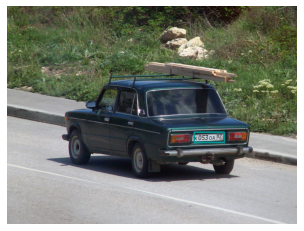

(57, 169, 3)


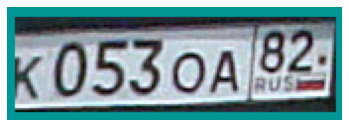

kK 0530A 82:
(480, 720, 3)


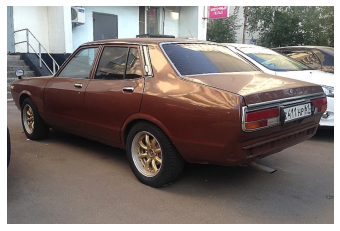

(980, 1300, 3)


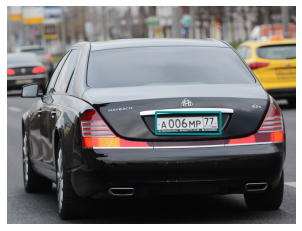

(97, 288, 3)


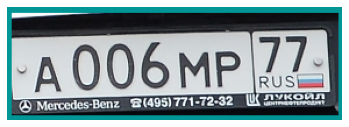

-A006mP JL
(1080, 1440, 3)


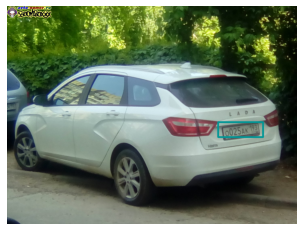

(74, 221, 3)


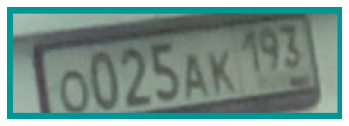

Thre
(1066, 1600, 3)


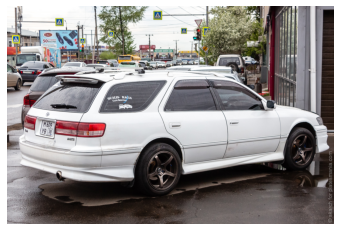

(1066, 1600, 3)


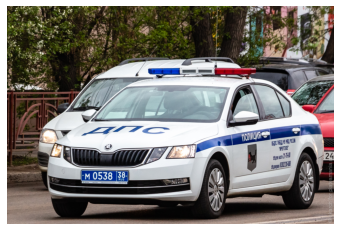

(1236, 1648, 3)


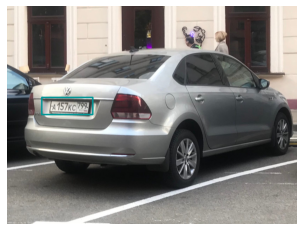

(97, 288, 3)


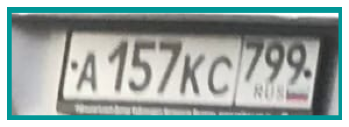


(1050, 1400, 3)


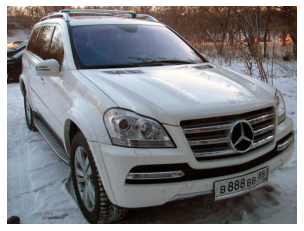

(1200, 1600, 3)


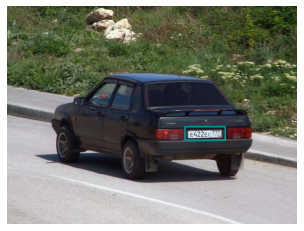

(74, 221, 3)


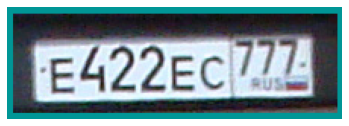


(1278, 1704, 3)


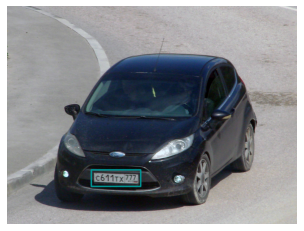

(97, 288, 3)


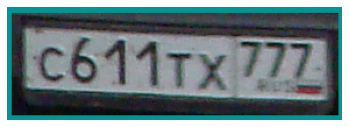


(1117, 1489, 3)


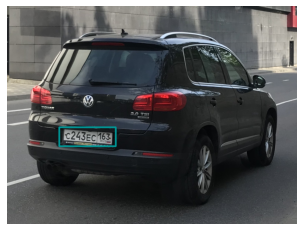

(97, 288, 3)


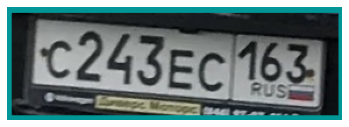


(1161, 1661, 3)


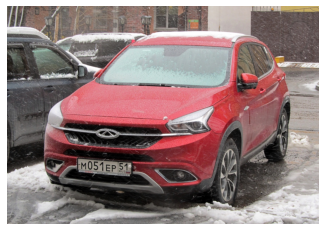

Detected Text :  ve


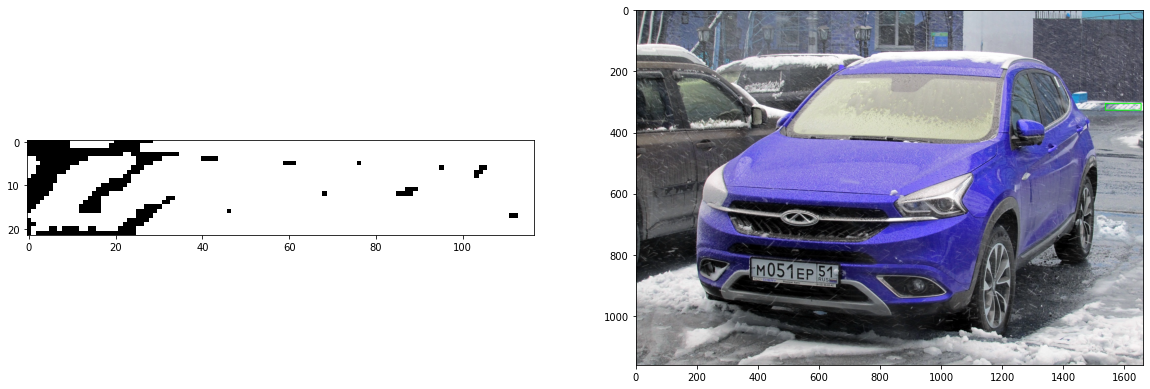

Detected Text :  Ver tisha fe


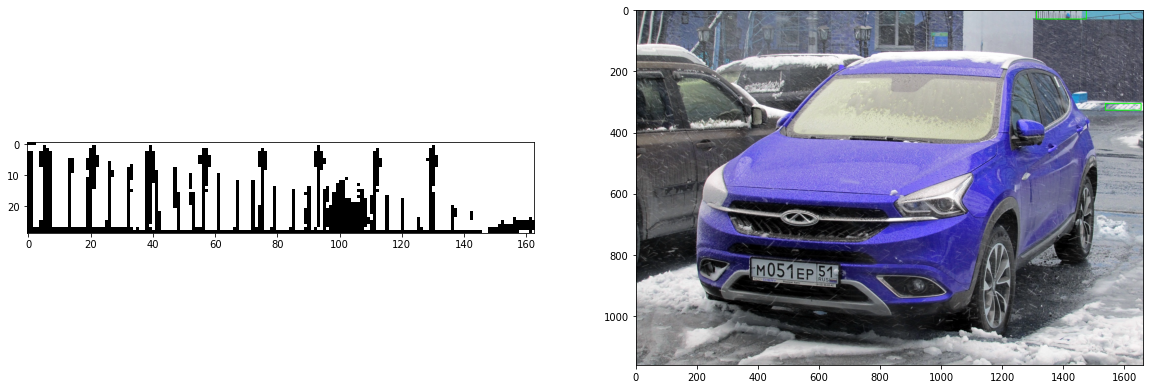

(1316, 1800, 3)


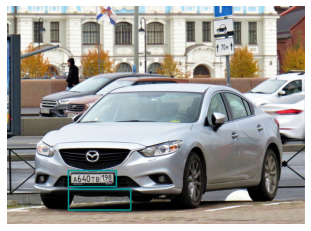

(97, 288, 3)


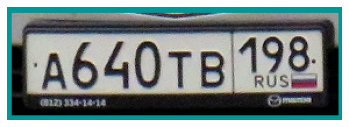

A640TB 198
(125, 372, 3)


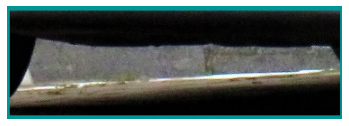

ae
(1080, 1440, 3)


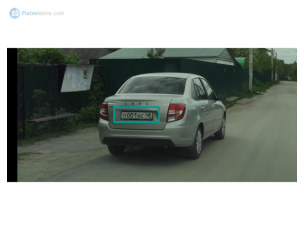

(74, 221, 3)


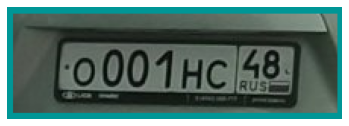

Meare
(888, 1245, 3)


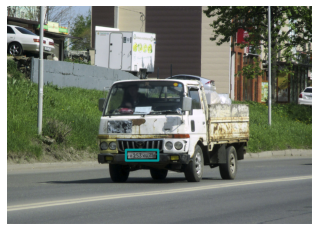

(44, 132, 3)


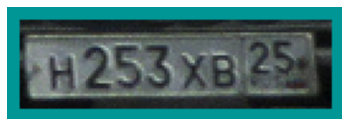

[1253 x aM
(1067, 1600, 3)


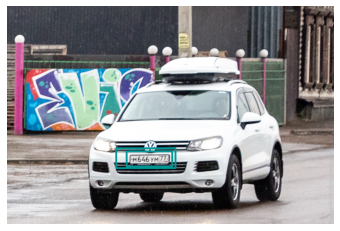

(97, 288, 3)


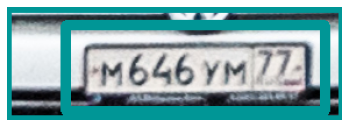

Bimzamall
(74, 221, 3)


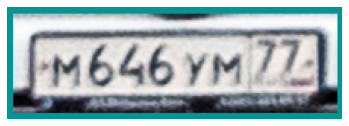

fm ba6 ym 77)
(1080, 1440, 3)


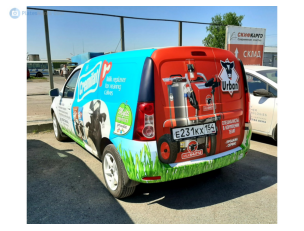

(683, 1024, 3)


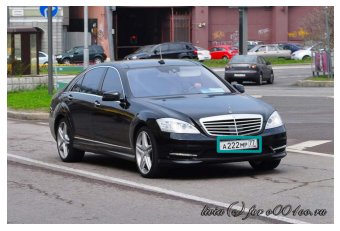

(44, 132, 3)


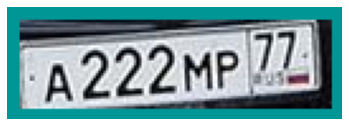

A222NP JL)
(1067, 1600, 3)


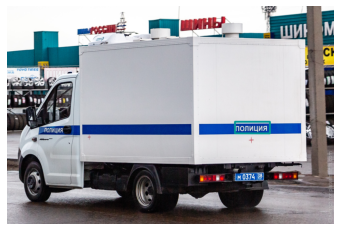

(57, 169, 3)


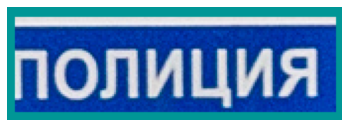

ree eT
(1080, 1440, 3)


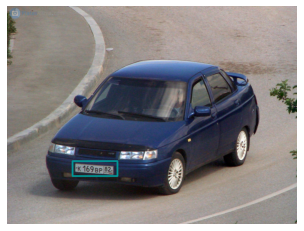

(74, 221, 3)


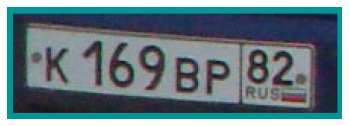


(1080, 1440, 3)


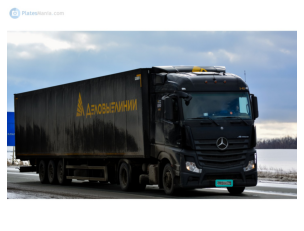

(26, 78, 3)


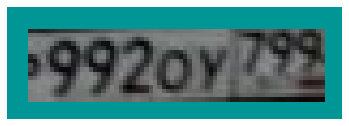


(889, 1163, 3)


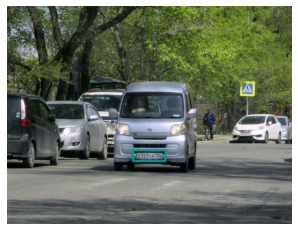

(44, 132, 3)


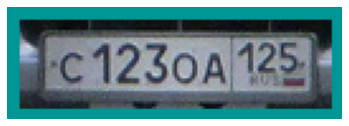


(1383, 1844, 3)


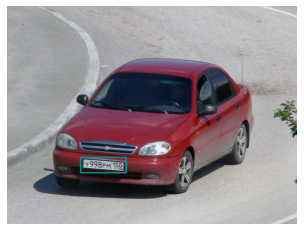

(97, 288, 3)


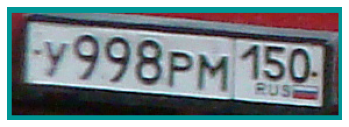

es
¥998PM 150.
(1080, 1440, 3)


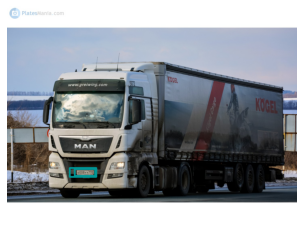

(34, 101, 3)


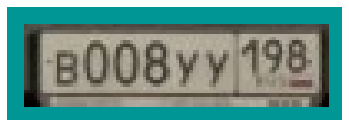


(44, 132, 3)


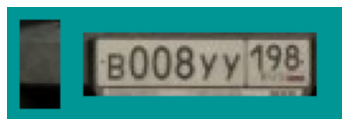

| | ema
(519, 967, 3)


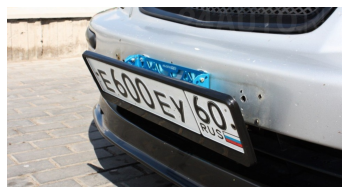

(1080, 1440, 3)


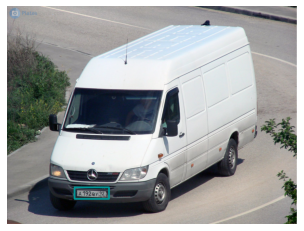

(57, 169, 3)


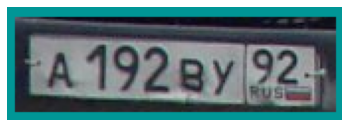


(1068, 1600, 3)


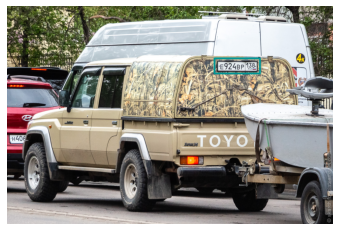

(74, 221, 3)


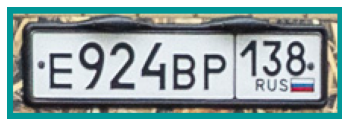

=) £924BP 138)
(1080, 1440, 3)


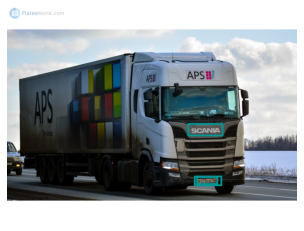

(57, 169, 3)


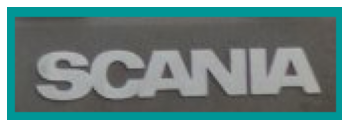

In [0]:
PATH = os.path.join(os.getcwd(), "input")
IMAGE_LIST = os.listdir(PATH)
count = len(IMAGE_LIST)/3
global count


# car_image = cv2.imread("input/2-1.jpg") 
# processing(car_image)

# car_image = cv2.imread("input/65.jpg") 
# callfunc(car_image)

#way = "license_plate.xml" 
way = "russian_plate_number.xml"
#way = "licence_plate_rus.xml"

for x in IMAGE_LIST:

  imagePath = os.path.join(PATH, x)
  car_image = cv2.imread(imagePath, 1) 
  processing(car_image, way, 1)
    #callfunc(car_image)

print("acc", (count/len(IMAGE_LIST)) * 100, "%")